# Visualization

This notebook leverages the cleaned data from `data_clean.ipynb` to create visualizations.
See description of each visualization below.

In [8]:
import math, os, json, time, re
import geojson
import geopandas as gpd
import matplotlib.pyplot as plt
from collections.abc import Iterable
from geopy.distance import geodesic
from pyproj import Transformer, Geod
from shapely.geometry import Polygon, Point
from shapely.ops import nearest_points

In [3]:
"""
Set custom python modules in PYTHONPATH to import and use them.
Set path to full dataset .json file.
"""

# Custom python modules
MODULENAME = "wildfire"
MODULEPATH = ""
try:
    ppath = os.environ.get('PYTHONPATH')
    if not ppath: raise
    MODULEPATH = os.path.join(ppath,MODULENAME)
except:
    # Likely here because a PYTHONPATH was not set, show a warning message
    print("Looks like you're not using a 'PYTHONPATH' to specify the location of your python user modules.")
    print("You may have to modify the sample code in this notebook to get the documented behaviors.")
    MODULEPATH = ""

# Import custom python methods
from wildfire.Reader import Reader as WFReader

Looks like you're not using a 'PYTHONPATH' to specify the location of your python user modules.
You may have to modify the sample code in this notebook to get the documented behaviors.


### Function description

The below function is reused for computing the distance a city is from a fire feature.

#### ASSUMPTION
The closest point of a fire feature is used to compute the distance from a city.

In [5]:
# Function for computing the distance of a feature to a city lat/lon coordinate
def distances(city_coords, gdf, miles, return_dist=False):
    """
    Compute distance of all features in a geopandas dataframe to a city lat/lon coorindates.
    
    Args:
        city_coords: 2-tuple of coordinates for a city in (lat,lon) format.
        gdf: A geopandas DataFrame. Should be the data loaded from the cleaned dataset produced via data_clean.ipynb
        miles: Integer, maximum number of miles a ring can be from the city to be saved and returned.
        return_dist: Boolean, returns distance of each ring from city if True.

    Returns:
        distance_filtered_features: list of geopandas rows/fire features that are within the miles range from the city
        dist_list: List with distance of each fire feature was from the city
    """
    dist_list = []
    city_point = Point(city_coords)
    distance_filtered_features = []
    for index, row in gdf.iterrows():
        polygon = row['geometry']
        nearest_point, _ = nearest_points(polygon, city_point)
        dist_miles = geodesic((nearest_point.y, nearest_point.x), city_coords).miles
        if dist_miles <= miles:
            distance_filtered_features.append(row)
            dist_list.append(dist_miles)
    if return_dist:
        return distance_filtered_features, dist_list
    else:
        return distance_filtered_features

In [6]:
"""
Load in clean dataset and then change its coordinate system so distance metrics
take into account lat/lon of city location and a spherical(ish) Earth.
"""
full_data_path = "./full_data.geojson"
gdf = gpd.read_file(full_data_path)

# Set the coordinate system of the data
gdf.crs = 'ESRI:102008'
print(gdf.crs)

# Change the coordinate system
gdf.to_crs(epsg=4326, inplace=True)

ESRI:102008


## Visualization 1: Histogram of Fires

Below is a visualization of the number of fires that occured over the entire timeframe of 1961-2020 based on distance from the city of Gainesville, FL. Each bin represents 50 miles from the city and the height of each bar in the histogram represents the total number of fires for the entire dataset that occured at that specific distance.

#### ASSUMPTIONS
1. The city coordinates are (lat,lon) obtained from Wikipedia.
2. The maximum distance a fire can be from the city to be part of the visualization is 1800 miles from the city.

In [7]:
# Coordinates for city Gainesville, FL
city_coords = (29.68, -82.35)

# Maximum number of miles from the city
MILES = 1800
fire_list = []
for year in range(1961,2022):
    year_gdf = gdf[gdf['Fire_Year'] == year]
    rows, distance_list = distances(city_coords, year_gdf, MILES, return_dist=True)
    fire_list.extend(distance_list)

Text(0.5, 1.0, 'Fires near Gainesville, FL')

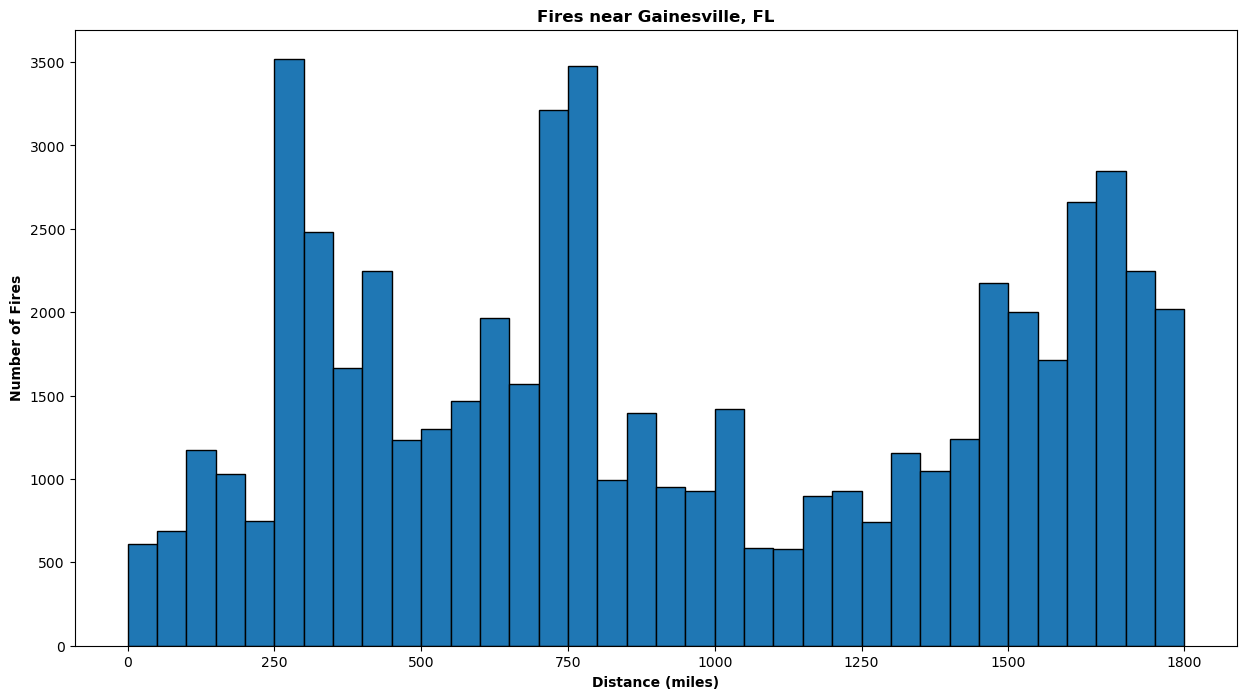

In [9]:
bin_width = 50
bins = range(0, 1800+bin_width, bin_width)
plt.figure(figsize=(15,8))
plt.xticks(ticks=[i for i in range(0, 1850, 250)][:-1] + [1800])
plt.hist(fire_list, bins=bins, edgecolor='black')
plt.xlabel('Distance (miles)', fontweight='bold')
plt.ylabel('Number of Fires', fontweight='bold')
plt.title('Fires near Gainesville, FL', fontweight='bold')

### Visualization 1 discussion

This is somewhat bimodel in a sense that there are kind of two clusters of many fires that occur near Gainesville -- the fires happen relatively close (within 800 miles) or really far away (1500 or more).

Something to note is that 1800 miles is a lot considering that the United States is roughly 2800 miles East to West. So, although the total number of fires within 1800 miles of Gainesville is over half of all clean fire features, it makes sense due to the large distance from the city.

## Visualization 2: Time Series of Acres burned per year

Below is a visualization of acres burned per year near Gainesville, FL.

#### ASSUMPTIONS
1. All fire features that were part of this visualization are 650 miles or closer to Gainesville, FL.

In [10]:
# Reusing the MILES and city_coords variables from cells above for visualization 1
annual_list = []
for year in range(1961,2022):
    year_gdf = gdf[gdf['Fire_Year'] == year]
    rows, _ = distances(city_coords, year_gdf, MILES, return_dist=True)

    # Add up the acres for each fire feature for entire year and add it to list
    annual_list.append(sum([r['GIS_Acres'] for r in rows]))

#### Visualiation 2 Part A Discussion

According to the visualization below, the vast majority of acres burned near Gainesville, FL have occured within the last decade.
Further, it appears that the number of acres that have burned have dramatically increased over time.
Part of this may be due to better measureing and diligence to do so, but it could also simply be that there truly were far more fires that resulted in more acres being burned.

Text(0.5, 1.0, 'Annual Acres Burned near Gainesville, FL')

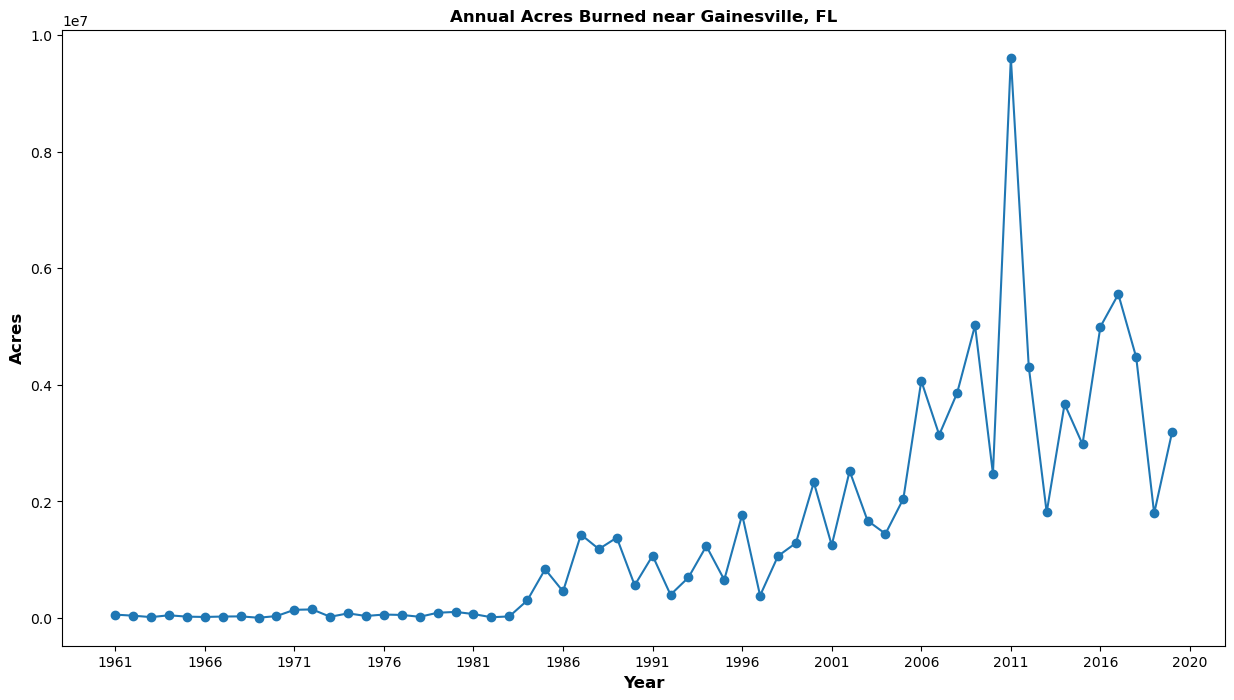

In [11]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(annual_list[:-1], marker='o')
ax.set_xticks(ticks=[i for i in range(0, len(annual_list[:-1]), 5)]+[60], labels=[i for i in range(1961, 2021, 5)]+[2020])
ax.set_xlabel('Year', fontweight='bold', fontsize=12)
ax.set_ylabel('Acres', fontweight='bold', fontsize=12)
ax.set_title('Annual Acres Burned near Gainesville, FL', fontweight='bold')

#### Visualiation 2 Part B Discussion

The Part A visualization above has a y-axis that is 1e6 scale so it was extremely difficult to understand visually how many acres were really burnt in the earlier years of measuring.

To visually emphasize that there were indeed measurements back in the 1960's to 1970's, the y-axis is now on a log-scale.

This is the same visualization, however with a log-scale.

Text(0.5, 1.0, 'Annual Acres Burned near Gainesville, FL  (Log Scale)')

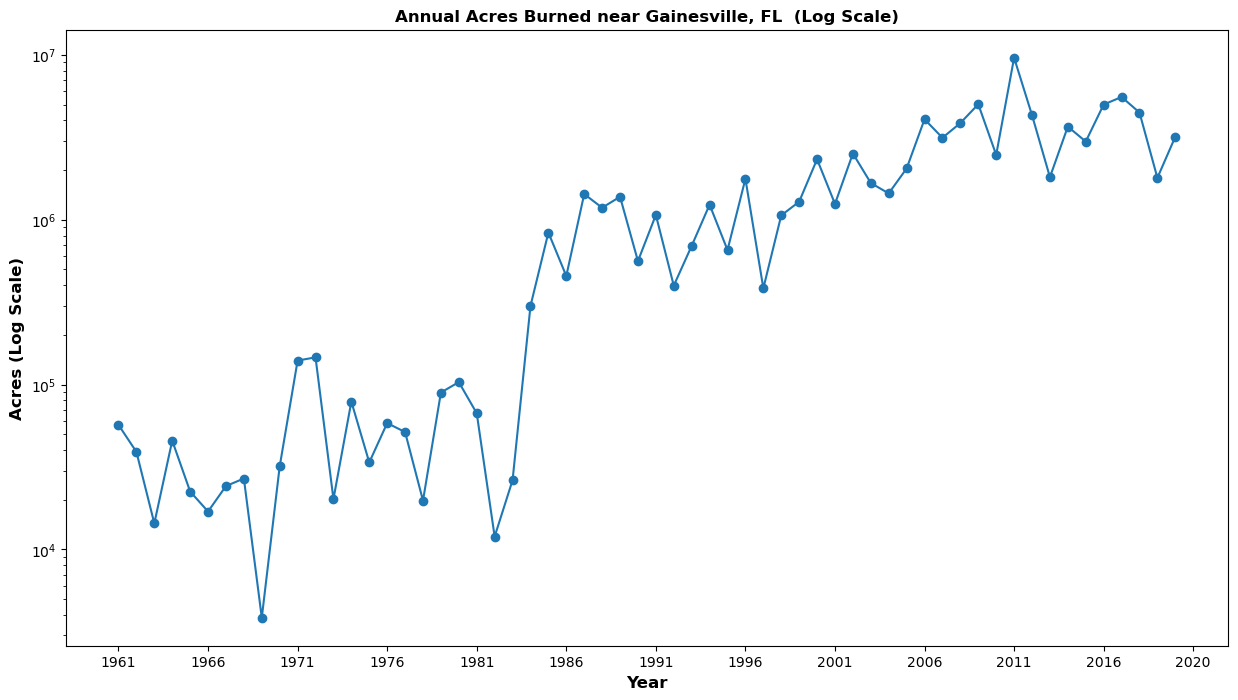

In [13]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(annual_list[:-1], marker='o')
ax.set_yscale('log')
ax.set_xticks(ticks=[i for i in range(0, len(annual_list), 5)], labels=[i for i in range(1961, 2022, 5)][:-1]+[2020])
ax.set_xlabel('Year', fontweight='bold', fontsize=12)
ax.set_ylabel('Acres (Log Scale)', fontweight='bold', fontsize=12)
ax.set_title('Annual Acres Burned near Gainesville, FL  (Log Scale)', fontweight='bold')